## CASSINI HACKATON 

### Autor: Hana Jurak 

-----------------------------------------------------------

In [ ]:
#! pip install global_land_mask
#! pip install basemap
#! pip install sgp4

In [ ]:
#! python -m pip uninstall numpy --yes
#! pip install numpy==1.22.0
#! pip install --upgrade numpy==1.20.0 --user

In [20]:
from sgp4.api import Satrec
from astropy.time import Time

from astropy.coordinates import TEME, ITRS, SkyCoord, AltAz
from astropy import units as u

import numpy as np
import pandas as pd

In [120]:
Sentinel_1A = list()
Sentinel_1A.append("1 39634U 14016A   23084.04767099 -.00000668  00000-0 -13193-3 0  9998")
Sentinel_1A.append("2 39634  98.1815  92.5824 0001234 102.5080 257.6325 14.59194175477942")

Sentinel_2A = list()
Sentinel_2A.append("1 40697U 15028A   23084.17253137  .00000936  00000-0  37372-3 0  9991")
Sentinel_2A.append("2 40697  98.5666 159.8801 0001280 103.1000 257.0360 14.30820555404998")

Sentinel_3A = list()
Sentinel_3A.append("1 41335U 16011A   23084.14109906  .00000393  00000-0  18032-3 0  9994")
Sentinel_3A.append("2 41335  98.6292 152.4033 0001002  98.2845 261.8449 14.26733680369799")

Sentinel_1B = list()
Sentinel_1B.append("1 41456U 16025A   23084.06732165  .00002413  00000-0  51447-3 0  9995")
Sentinel_1B.append("2 41456  98.1815  92.4676 0001416 105.4859 254.6457 14.59807899368114")

satellites = [Sentinel_1A, Sentinel_2A, Sentinel_3A, Sentinel_1B]

area = [[0, 15],[0, 15]] # lat, long

In [22]:
satellite = Satrec.twoline2rv(Sentinel_1A[0], Sentinel_1A[1])       # TLE strings to satellite record
jd, fr = satellite.jdsatepoch, satellite.jdsatepochF                # Julian date and fractional Julian date
e, r, v = satellite.sgp4(jd, fr)


if e == 0:
    print('\nLocation of satellite in TEME ->', r, 'km')  # True Equator Mean Equinox position (km)
    print('\nVelocity of satellite in TEME ->', v, 'km/s')  # True Equator Mean Equinox velocity (km/s)
    
    
else:
    print("Satellite position can't be computed for the given date.")
    

    
    
satellite_recorded_time = Time(satellite.jdsatepoch + satellite.jdsatepochF, format='jd')  # Time of the epoch of the TLE set 


print('\nSatellite current UTC time ->', satellite_recorded_time.datetime)



Location of satellite in TEME -> (-318.74779813417734, 7069.903142318956, 0.8225510447836747) km

Velocity of satellite in TEME -> (1.06689916993554, 0.03846261828690485, 7.430165360984037) km/s

Satellite current UTC time -> 2023-03-25 01:08:38.773556


In [27]:
satellite_location_teme = SkyCoord(x = r[0] * u.km, y = r[1] * u.km, z = r[2] * u.km, 
                                   obstime = satellite_recorded_time, frame='teme') 

itrs = ITRS(obstime = Time(satellite_recorded_time.datetime))   

satellite_location_itrs = satellite_location_teme.transform_to(itrs)   # (x, y, z) in km



print('\nLocation of satellite in ITRS ->', 
      (satellite_location_itrs.x.value, satellite_location_itrs.y.value, satellite_location_itrs.z.value), 'km')


Location of satellite in ITRS -> (-2048.7031041448245, -6774.06423151939, 0.8096258681777233) km


In [121]:
from astral.sun import sun

import time
start_time = time.time()


Sentinel_1A = list()
Sentinel_1A.append("1 39634U 14016A   23084.04767099 -.00000668  00000-0 -13193-3 0  9998")
Sentinel_1A.append("2 39634  98.1815  92.5824 0001234 102.5080 257.6325 14.59194175477942")

NEXT_HOURS = 24
N_POINTS = 2 * 60 * NEXT_HOURS

d = np.linspace(0, NEXT_HOURS, N_POINTS) 
df = pd.DataFrame(data = d, columns = ['t_passed']) 


satellite = Satrec.twoline2rv(Sentinel_1A[0], Sentinel_1A[1])      
jd, fr = satellite.jdsatepoch, satellite.jdsatepochF                
satellite_recorded_time = Time(satellite.jdsatepoch + satellite.jdsatepochF, format='jd')  

df["UTC"] = (satellite_recorded_time + df["t_passed"]/24.).datetime   # UTC time for future propagation 
err, ar2, ar3 = satellite.sgp4_array(Time(df.UTC).jd1, Time(df.UTC).jd2)
df["TEME"] = ar2.tolist() # in km

df.drop('t_passed', inplace=True, axis=1)


latitude_1A = []
longitude_1A = []

in_area = list()


def earth_observables(row):
    
    satellite_location_teme = SkyCoord(x = row.TEME[0] * u.km, y = row.TEME[1] * u.km, z = row.TEME[2] * u.km, 
                                       obstime = row['UTC'], frame='teme') 
    
    itrs = ITRS(obstime = Time(row['UTC']))   
    satellite_location_itrs = satellite_location_teme.transform_to(itrs)  
    
    itrs = satellite_location_teme.transform_to(ITRS(obstime=Time(row['UTC'])))  
    satellite_location_earth = satellite_location_itrs.earth_location
    latitude_1A.append(satellite_location_earth.geodetic.lat.value)
    longitude_1A.append(satellite_location_earth.geodetic.lon.value)
    
    if (satellite_location_earth.geodetic.lat.value >= area[0][0] 
        and satellite_location_earth.geodetic.lat.value <= area[0][1] 
        and satellite_location_earth.geodetic.lon.value >= area[1][0] 
        and satellite_location_earth.geodetic.lon.value <= area[1][1]):
        
        lat_lon = [satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value]
        in_area.append(lat_lon)


    return (satellite_location_itrs, satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value)

    

df['ITRS'], df['Latitude'], df['Longitude'] = zip(*df.apply(earth_observables,axis=1 ))





print("--- %s seconds ---" % (time.time() - start_time))

df

--- 34.431944608688354 seconds ---


,UTC,TEME,ITRS,Latitude,Longitude
0,2023-03-25 01:08:38.773556,"[-318.74777679613425, 7069.903143088301, 0.822...",<SkyCoord (ITRS: obstime=2023-03-25 01:08:38.7...,0.006596,-106.827069
1,2023-03-25 01:09:08.783976,"[-286.57338734004804, 7067.472646467624, 223.7...",<SkyCoord (ITRS: obstime=2023-03-25 01:09:08.7...,1.822865,-107.211926
2,2023-03-25 01:09:38.794396,"[-254.1083664928528, 7057.874678581494, 446.48...",<SkyCoord (ITRS: obstime=2023-03-25 01:09:38.7...,3.639186,-107.597321
3,2023-03-25 01:10:08.804817,"[-221.3856128077682, 7041.118286134538, 668.74...",<SkyCoord (ITRS: obstime=2023-03-25 01:10:08.8...,5.455477,-107.983775
4,2023-03-25 01:10:38.815237,"[-188.43829824600974, 7017.219855704031, 890.3...",<SkyCoord (ITRS: obstime=2023-03-25 01:10:38.8...,7.271654,-108.371817
...,...,...,...,...,...
2875,2023-03-26 01:06:38.731875,"[13.06803673298442, -6530.691309487715, -2733....",<SkyCoord (ITRS: obstime=2023-03-26 01:06:38.7...,-22.832618,70.222049
2876,2023-03-26 01:07:08.742295,"[-21.822180862694378, -6441.751879672187, -293...",<SkyCoord (ITRS: obstime=2023-03-26 01:07:08.7...,-24.640008,69.787919
2877,2023-03-26 01:07:38.752715,"[-56.6903184522004, -6346.294893547401, -3137....",<SkyCoord (ITRS: obstime=2023-03-26 01:07:38.7...,-26.446085,69.344831
2878,2023-03-26 01:08:08.763135,"[-91.50111098615626, -6244.418405943937, -3335...",<SkyCoord (ITRS: obstime=2023-03-26 01:08:08.7...,-28.250746,68.891736


In [128]:
from astral.sun import sun

import time
start_time = time.time()


Sentinel_2A = list()
Sentinel_2A.append("1 40697U 15028A   23084.17253137  .00000936  00000-0  37372-3 0  9991")
Sentinel_2A.append("2 40697  98.5666 159.8801 0001280 103.1000 257.0360 14.30820555404998")

NEXT_HOURS = 24
N_POINTS = 2 * 60 * NEXT_HOURS

d = np.linspace(0, NEXT_HOURS, N_POINTS) 
df = pd.DataFrame(data = d, columns = ['t_passed']) 


satellite = Satrec.twoline2rv(Sentinel_2A[0], Sentinel_2A[1])      
jd, fr = satellite.jdsatepoch, satellite.jdsatepochF                
satellite_recorded_time = Time(satellite.jdsatepoch + satellite.jdsatepochF, format='jd')  

df["UTC"] = (satellite_recorded_time + df["t_passed"]/24.).datetime   # UTC time for future propagation 
err, ar2, ar3 = satellite.sgp4_array(Time(df.UTC).jd1, Time(df.UTC).jd2)
df["TEME"] = ar2.tolist() # in km

df.drop('t_passed', inplace=True, axis=1)


latitude_2A = []
longitude_2A = []

in_area = list()

def earth_observables(row):
    
    satellite_location_teme = SkyCoord(x = row.TEME[0] * u.km, y = row.TEME[1] * u.km, z = row.TEME[2] * u.km, 
                                       obstime = row['UTC'], frame='teme') 
    
    itrs = ITRS(obstime = Time(row['UTC']))   
    satellite_location_itrs = satellite_location_teme.transform_to(itrs)  
    
    itrs = satellite_location_teme.transform_to(ITRS(obstime=Time(row['UTC'])))  
    satellite_location_earth = satellite_location_itrs.earth_location
    latitude_2A.append(satellite_location_earth.geodetic.lat.value)
    longitude_2A.append(satellite_location_earth.geodetic.lon.value)
    
    if (satellite_location_earth.geodetic.lat.value >= area[0][0] 
        and satellite_location_earth.geodetic.lat.value <= area[0][1] 
        and satellite_location_earth.geodetic.lon.value >= area[1][0] 
        and satellite_location_earth.geodetic.lon.value <= area[1][1]):
        
        lat_lon = [satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value]
        in_area.append(lat_lon)



    return (satellite_location_itrs, satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value)

    

df['ITRS'], df['Latitude'], df['Longitude'] = zip(*df.apply(earth_observables,axis=1 ))






print("--- %s seconds ---" % (time.time() - start_time))

df

--- 30.330584049224854 seconds ---


,UTC,TEME,ITRS,Latitude,Longitude
0,2023-03-25 04:08:26.710374,"[-6732.677053101003, 2466.529855650638, 0.4238...",<SkyCoord (ITRS: obstime=2023-03-25 04:08:26.7...,0.003301,-84.601726
1,2023-03-25 04:08:56.720795,"[-6717.680688232047, 2496.5119985087604, 221.6...",<SkyCoord (ITRS: obstime=2023-03-25 04:08:56.7...,1.782367,-84.993430
2,2023-03-25 04:09:26.731215,"[-6696.133979623642, 2524.0598195243692, 442.7...",<SkyCoord (ITRS: obstime=2023-03-25 04:09:26.7...,3.561482,-85.385664
3,2023-03-25 04:09:56.741635,"[-6668.057324424675, 2549.146227292264, 663.37...",<SkyCoord (ITRS: obstime=2023-03-25 04:09:56.7...,5.340564,-85.778939
4,2023-03-25 04:10:26.752055,"[-6633.477556499461, 2571.7465492807064, 883.3...",<SkyCoord (ITRS: obstime=2023-03-25 04:10:26.7...,7.119531,-86.173777
...,...,...,...,...,...
2875,2023-03-26 04:06:26.668693,"[1635.8846301700517, 541.0326829164713, 6948.5...",<SkyCoord (ITRS: obstime=2023-03-26 04:06:26.6...,76.153002,133.335395
2876,2023-03-26 04:06:56.679114,"[1840.5991009008412, 462.73168626828874, 6902....",<SkyCoord (ITRS: obstime=2023-03-26 04:06:56.6...,74.714322,129.021328
2877,2023-03-26 04:07:26.689534,"[2043.5213360636178, 383.9801095057225, 6850.5...",<SkyCoord (ITRS: obstime=2023-03-26 04:07:26.6...,73.210789,125.425898
2878,2023-03-26 04:07:56.699954,"[2244.453655564592, 304.854613719035, 6791.526...",<SkyCoord (ITRS: obstime=2023-03-26 04:07:56.6...,71.658249,122.393526


In [126]:


NEXT_HOURS = 24
N_POINTS = 2 * 60 * NEXT_HOURS

d = np.linspace(0, NEXT_HOURS, N_POINTS) 
df = pd.DataFrame(data = d, columns = ['t_passed']) 


satellite = Satrec.twoline2rv(Sentinel_3A[0], Sentinel_3A[1])      
jd, fr = satellite.jdsatepoch, satellite.jdsatepochF                
satellite_recorded_time = Time(satellite.jdsatepoch + satellite.jdsatepochF, format='jd')  

df["UTC"] = (satellite_recorded_time + df["t_passed"]/24.).datetime   # UTC time for future propagation 
err, ar2, ar3 = satellite.sgp4_array(Time(df.UTC).jd1, Time(df.UTC).jd2)
df["TEME"] = ar2.tolist() # in km

df.drop('t_passed', inplace=True, axis=1)


latitude_3A = []
longitude_3A = []

in_area = list()


def earth_observables(row):
    
    satellite_location_teme = SkyCoord(x = row.TEME[0] * u.km, y = row.TEME[1] * u.km, z = row.TEME[2] * u.km, 
                                       obstime = row['UTC'], frame='teme') 
    
    itrs = ITRS(obstime = Time(row['UTC']))   
    satellite_location_itrs = satellite_location_teme.transform_to(itrs)  
    
    itrs = satellite_location_teme.transform_to(ITRS(obstime=Time(row['UTC'])))  
    satellite_location_earth = satellite_location_itrs.earth_location
    latitude_3A.append(satellite_location_earth.geodetic.lat.value)
    longitude_3A.append(satellite_location_earth.geodetic.lon.value)
    
    if (satellite_location_earth.geodetic.lat.value >= area[0][0] 
        and satellite_location_earth.geodetic.lat.value <= area[0][1] 
        and satellite_location_earth.geodetic.lon.value >= area[1][0] 
        and satellite_location_earth.geodetic.lon.value <= area[1][1]):
        
        lat_lon = [satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value]
        in_area.append(lat_lon)



    return (satellite_location_itrs, satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value)

    

df['ITRS'], df['Latitude'], df['Longitude'] = zip(*df.apply(earth_observables,axis=1 ))


df

,UTC,TEME,ITRS,Latitude,Longitude
0,2023-03-25 03:23:10.958780,"[-6366.532039836229, 3327.8755315723906, -0.00...",<SkyCoord (ITRS: obstime=2023-03-25 03:23:10.9...,-0.000109,-80.731402
1,2023-03-25 03:23:40.969200,"[-6347.693651260637, 3355.8529958240897, 221.0...",<SkyCoord (ITRS: obstime=2023-03-25 03:23:40.9...,1.773616,-81.124280
2,2023-03-25 03:24:10.979621,"[-6322.700740180175, 3380.5767361643934, 441.8...",<SkyCoord (ITRS: obstime=2023-03-25 03:24:10.9...,3.547386,-81.517684
3,2023-03-25 03:24:40.990041,"[-6291.576982715129, 3402.022481332545, 662.22...",<SkyCoord (ITRS: obstime=2023-03-25 03:24:40.9...,5.321120,-81.912127
4,2023-03-25 03:25:11.000461,"[-6254.352061960952, 3420.16916925068, 881.966...",<SkyCoord (ITRS: obstime=2023-03-25 03:25:11.0...,7.094736,-82.308128
...,...,...,...,...,...
2875,2023-03-26 03:21:10.917099,"[68.91180453678092, 1167.435442733767, 7076.67...",<SkyCoord (ITRS: obstime=2023-03-26 03:21:10.9...,80.670975,-146.996442
2876,2023-03-26 03:21:40.927519,"[269.3644776854734, 1068.8281105715434, 7087.4...",<SkyCoord (ITRS: obstime=2023-03-26 03:21:40.9...,81.211714,-157.888611
2877,2023-03-26 03:22:10.937939,"[469.55641815916704, 969.1862134172914, 7091.3...",<SkyCoord (ITRS: obstime=2023-03-26 03:22:10.9...,81.415081,-169.718393
2878,2023-03-26 03:22:40.948360,"[669.2938617793493, 868.6061970415144, 7088.31...",<SkyCoord (ITRS: obstime=2023-03-26 03:22:40.9...,81.257516,178.390125


In [125]:
NEXT_HOURS = 24
N_POINTS = 2 * 60 * NEXT_HOURS

d = np.linspace(0, NEXT_HOURS, N_POINTS) 
df = pd.DataFrame(data = d, columns = ['t_passed']) 


satellite = Satrec.twoline2rv(Sentinel_1B[0], Sentinel_1B[1])      
jd, fr = satellite.jdsatepoch, satellite.jdsatepochF                
satellite_recorded_time = Time(satellite.jdsatepoch + satellite.jdsatepochF, format='jd')  

df["UTC"] = (satellite_recorded_time + df["t_passed"]/24.).datetime   # UTC time for future propagation 
err, ar2, ar3 = satellite.sgp4_array(Time(df.UTC).jd1, Time(df.UTC).jd2)
df["TEME"] = ar2.tolist() # in km

df.drop('t_passed', inplace=True, axis=1)


latitude_1B = []
longitude_1B = []

in_area = list()

def earth_observables(row):
    
    satellite_location_teme = SkyCoord(x = row.TEME[0] * u.km, y = row.TEME[1] * u.km, z = row.TEME[2] * u.km, 
                                       obstime = row['UTC'], frame='teme') 
    
    itrs = ITRS(obstime = Time(row['UTC']))   
    satellite_location_itrs = satellite_location_teme.transform_to(itrs)  
    
    itrs = satellite_location_teme.transform_to(ITRS(obstime=Time(row['UTC'])))  
    satellite_location_earth = satellite_location_itrs.earth_location
    latitude_1B.append(satellite_location_earth.geodetic.lat.value)
    longitude_1B.append(satellite_location_earth.geodetic.lon.value)

    if (satellite_location_earth.geodetic.lat.value >= area[0][0] 
        and satellite_location_earth.geodetic.lat.value <= area[0][1] 
        and satellite_location_earth.geodetic.lon.value >= area[1][0] 
        and satellite_location_earth.geodetic.lon.value <= area[1][1]):
        
        lat_lon = [satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value]
        in_area.append(lat_lon)


    return (satellite_location_itrs, satellite_location_earth.geodetic.lat.value, satellite_location_earth.geodetic.lon.value)

    

df['ITRS'], df['Latitude'], df['Longitude'] = zip(*df.apply(earth_observables,axis=1 ))

df

,UTC,TEME,ITRS,Latitude,Longitude
0,2023-03-25 01:36:56.590579,"[-304.68895126654013, 7068.6189241959955, -0.4...",<SkyCoord (ITRS: obstime=2023-03-25 01:36:56.5...,-0.004125,-114.033941
1,2023-03-25 01:37:26.600999,"[-272.51686689959746, 7066.160850171065, 222.4...",<SkyCoord (ITRS: obstime=2023-03-25 01:37:26.6...,1.812871,-114.418900
2,2023-03-25 01:37:56.611419,"[-240.06818286782027, 7056.5308368442065, 445....",<SkyCoord (ITRS: obstime=2023-03-25 01:37:56.6...,3.629922,-114.804394
3,2023-03-25 01:38:26.621840,"[-207.3758087144692, 7039.737958755433, 667.52...",<SkyCoord (ITRS: obstime=2023-03-25 01:38:26.6...,5.446944,-115.190946
4,2023-03-25 01:38:56.632260,"[-174.47291330703774, 7015.798640693355, 889.1...",<SkyCoord (ITRS: obstime=2023-03-25 01:38:56.6...,7.263854,-115.579084
...,...,...,...,...,...
2875,2023-03-26 01:34:56.548898,"[-41.96397988061451, -6420.280606115006, -2978...",<SkyCoord (ITRS: obstime=2023-03-26 01:34:56.5...,-25.020624,62.639311
2876,2023-03-26 01:35:26.559318,"[-76.63482925509095, -6323.382309091307, -3178...",<SkyCoord (ITRS: obstime=2023-03-26 01:35:26.5...,-26.827186,62.194067
2877,2023-03-26 01:35:56.569738,"[-111.22809660128715, -6220.082541916556, -337...",<SkyCoord (ITRS: obstime=2023-03-26 01:35:56.5...,-28.632308,61.738574
2878,2023-03-26 01:36:26.580159,"[-145.70878956463338, -6110.487370659442, -356...",<SkyCoord (ITRS: obstime=2023-03-26 01:36:26.5...,-30.435881,61.271651


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


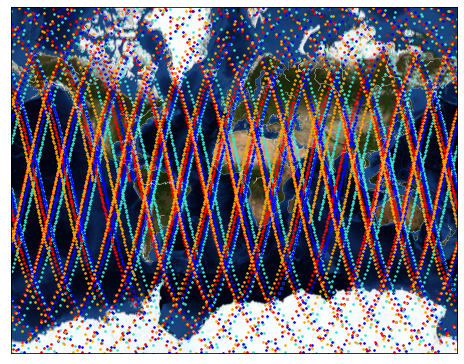

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap




fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

a, b = m(longitude_1A, latitude_1A)  # transform coordinates
c, d = m(longitude_2A, latitude_2A)
e, f = m(longitude_3A, latitude_3A)
g, h = m(longitude_1B, latitude_1B)
plt.scatter(a, b, 10, marker='.', color='Turquoise') 
plt.scatter(c, d, 10, marker='.', color='Red') 
plt.scatter(e, f, 10, marker='.', color='Blue') 
plt.scatter(g, h, 10, marker='.', color='Orange') 


plt.savefig('cassini_world.png')

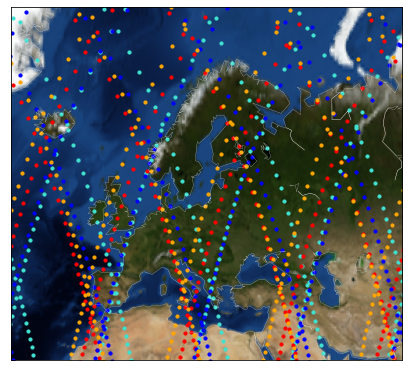

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap





fig = plt.gcf()
fig.set_size_inches(8, 6.5)

m = Basemap(projection='merc', \
            llcrnrlat=25, urcrnrlat=75, \
            llcrnrlon=-30, urcrnrlon=70, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

a, b = m(longitude_1A, latitude_1A)  # transform coordinates
c, d = m(longitude_2A, latitude_2A)
e, f = m(longitude_3A, latitude_3A)
g, h = m(longitude_1B, latitude_1B)
plt.scatter(a, b, 10, marker='o', color='Turquoise') 
plt.scatter(c, d, 10, marker='o', color='Red') 
plt.scatter(e, f, 10, marker='o', color='Blue') 
plt.scatter(g, h, 10, marker='o', color='Orange') 


plt.savefig('cassini_europe.png')